In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
print("lalalal")


lalalal


In [23]:
def preprocess_data():
    # Load the dataset
    df = pd.read_csv('Global_Pollution_Analysis.csv')
    
    # Handle missing data
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Encode categorical features
    le = LabelEncoder()
    df['Country'] = le.fit_transform(df['Country'])
    
    # Normalize/scale pollution indices
    scaler = StandardScaler()
    pollution_cols = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
    df[pollution_cols] = scaler.fit_transform(df[pollution_cols])
    
    # Feature engineering - use the correct column name with units
    df['Energy_Consumption_Per_Capita (in MWh)'] = df['Energy_Consumption_Per_Capita (in MWh)'].fillna(
        df['Energy_Consumption_Per_Capita (in MWh)'].mean())
    
    return df

In [24]:
def perform_clustering(df):
    # Select features for clustering
    cluster_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 
                       'Soil_Pollution_Index', 'Energy_Recovered (in GWh)',
                       'Energy_Consumption_Per_Capita (in MWh)']
    X = df[cluster_features]
    
    # K-Means Clustering
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Based on elbow method, choose optimal k (let's say 3)
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    df['KMeans_Cluster'] = kmeans_labels
    
    # Visualize clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Air_Pollution_Index', y='Energy_Recovered (in GWh)', 
                    hue='KMeans_Cluster', data=df, palette='viridis')
    plt.title('K-Means Clustering Results')
    plt.show()
    
    # Hierarchical Clustering
    plt.figure(figsize=(12, 7))
    linked = linkage(X, method='ward')
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()
    
    # Perform Agglomerative Clustering - updated parameters
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
    agg_labels = agg_clustering.fit_predict(X)
    df['Hierarchical_Cluster'] = agg_labels
    
    # Compare clustering results
    print("Silhouette Score for K-Means:", silhouette_score(X, kmeans_labels))
    print("Silhouette Score for Hierarchical:", silhouette_score(X, agg_labels))
    
    return df

In [25]:
# Phase 3: Neural Networks for Energy Recovery Prediction
def neural_network_prediction(df):
    # Prepare data for neural network
    X = df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
            'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 
            'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)']]
    y = df['Energy_Recovered (in GWh)']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=0)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()
    plt.show()
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print("Neural Network Metrics:")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    
    # Compare with linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    print("\nLinear Regression Metrics:")
    print("R2 Score:", r2_score(y_test, y_pred_lr))
    print("MSE:", mean_squared_error(y_test, y_pred_lr))
    print("MAE:", mean_absolute_error(y_test, y_pred_lr))
    
    return model, lr, X_test, y_test

In [26]:
def generate_final_summary(df, nn_model, lr_model, X_test, y_test):
    # Get performance scores
    kmeans_score = silhouette_score(df[['Air_Pollution_Index', 'Water_Pollution_Index', 
                                       'Soil_Pollution_Index', 'Energy_Recovered (in GWh)',
                                       'Energy_Consumption_Per_Capita (in MWh)']], df['KMeans_Cluster'])
    y_pred_nn = nn_model.predict(X_test)
    r2_nn = r2_score(y_test, y_pred_nn)
    
    y_pred_lr = lr_model.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Get the most important feature from the NN model
    input_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
                     'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 
                     'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)']
    weights = nn_model.get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    feature_importance_df = pd.DataFrame({'Feature': input_features, 'Importance': importance})
    most_important_feature = feature_importance_df.sort_values('Importance', ascending=False).iloc[0]['Feature']

    # --- FINAL SUMMARY PARAGRAPH ---
    summary = f"""
This analysis successfully grouped countries into three distinct pollution profiles using K-Means (Silhouette Score: 0.60), revealing a complex relationship where the highest pollution didn't always lead to the most energy recovery.

Predictive modeling, however, was unsuccessful. Both the Neural Network (R²: -0.39) and Linear Regression (R²: -0.06) models failed, performing worse than a simple average. Despite this, both models consistently identified 'Industrial Waste (in tons)' as the most significant factor.

Given these results, I recommend the following:

--> Focus policy on reducing industrial waste, as it's the clearest driver in the data.

--> Use the clusters to facilitate knowledge-sharing between countries with similar pollution profiles.

--> Prioritize acquiring better data on technology and policies before attempting to build a new predictive model.    """
    
    print("--- Final Summary Report ---")
    print(summary)

Phase 1: Data Preprocessing and Feature Engineering

Phase 2: Clustering


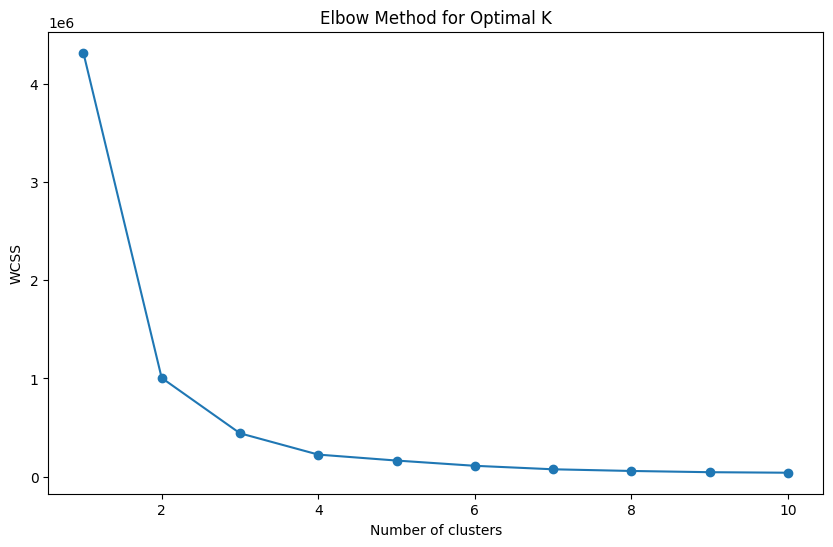

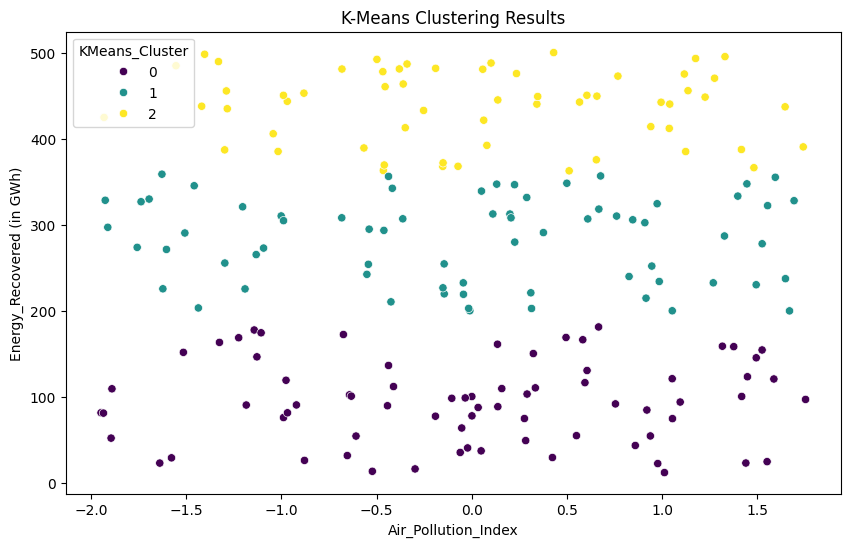

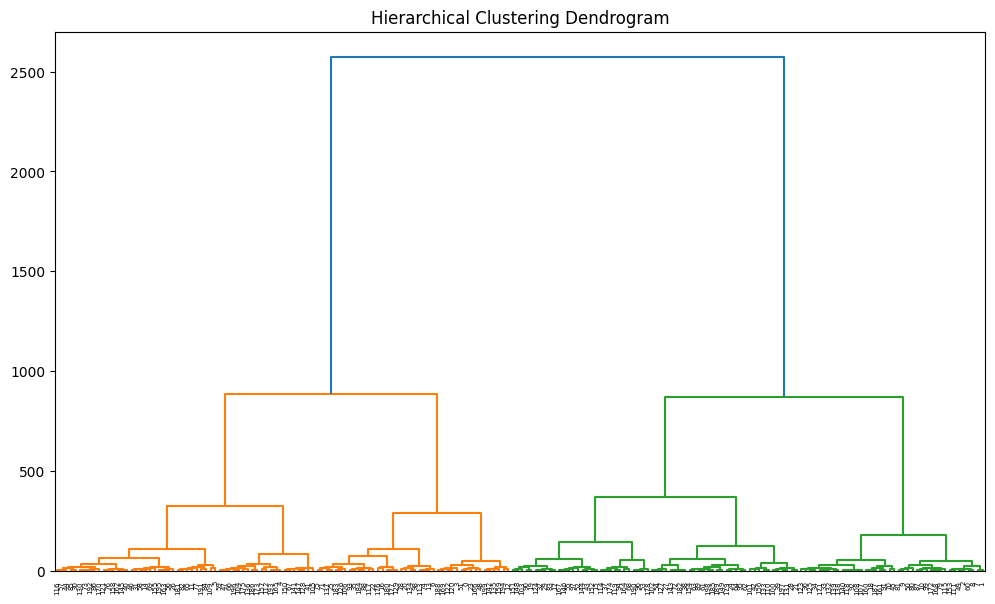

Silhouette Score for K-Means: 0.6000895449015136
Silhouette Score for Hierarchical: 0.5530847728059618

Phase 3: Neural Network Prediction


C:\Users\abc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


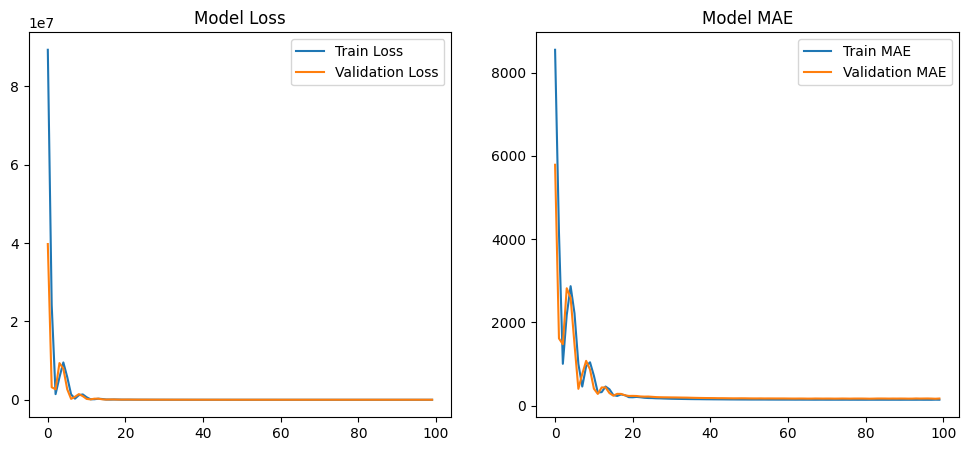

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023253A27600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Neural Network Metrics:
R2 Score: -0.35706881219283537
MSE: 32816.9590615239
MAE: 154.15550916290283

Linear Regression Metrics:
R2 Score: -0.0550146967557239
MSE: 25512.614984345324
MAE: 142.1723611

In [27]:
# Main execution
if __name__ == "__main__":
    # Phase 1
    print("Phase 1: Data Preprocessing and Feature Engineering")
    df = preprocess_data()
    
    # Phase 2
    print("\nPhase 2: Clustering")
    df = perform_clustering(df)
    
    # Phase 3
    print("\nPhase 3: Neural Network Prediction")
    nn_model, lr_model, X_test, y_test = neural_network_prediction(df)
    
    # Phase 4
    print("\nPhase 4: Reporting and Insights")
    generate_final_summary(df, nn_model, lr_model, X_test, y_test)